# Creating a TorchModel
Base models built in PyTorch are already supported by LUME-model. We demonstrate how to create and execute a `TorchModel` below.

In [2]:
import torch
import torch.nn as nn
from botorch.models.transforms.input import AffineInputTransform

from lume_model.models import TorchModel, TorchModule
from lume_model.variables import ScalarVariable

## Building a Model from Scratch
Instantiation of a `TorchModel` requires specification of the base model (`torch.nn.Module`) and in-/output variables.

In [3]:
# exemplary model definition
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.linear = nn.Linear(2, 1)

        # explicitly set weights and biases
        self.linear.weight = nn.Parameter(torch.tensor([[0.05, -0.5]]))
        self.linear.bias = nn.Parameter(torch.tensor([0.5]))

    def forward(self, x):
        return self.linear(x)

base_model = BaseModel()

# variable specification
input_variables = [
    ScalarVariable(name="input1", default_value=0.1, value_range=[0.0, 1.0]),
    ScalarVariable(name="input2", default_value=0.2, value_range=[0.0, 1.0]),
]
output_variables = [
    ScalarVariable(name="output"),
]

# specify input/output transformers
input_transform_0 = AffineInputTransform(d=2, coefficient=torch.tensor([2.0]), offset=torch.tensor([1.0]))
input_transform_1 = input_transform_0
output_transform_0 = input_transform_0
output_transform_1 = input_transform_0

input_transformers=[input_transform_0, input_transform_1]
output_transformers=[output_transform_0, output_transform_1]

# creation of TorchModel
example_model = TorchModel(
    model=base_model,
    input_variables=input_variables,
    output_variables=output_variables,
    fixed_model=True,
    input_transformers=input_transformers, 
    output_transformers=output_transformers
)

In [4]:
example_model

TorchModel(input_variables=[ScalarVariable(name='input1', default_value=0.1, value_range=(0.0, 1.0), is_constant=False, unit=None), ScalarVariable(name='input2', default_value=0.2, value_range=(0.0, 1.0), is_constant=False, unit=None)], output_variables=[ScalarVariable(name='output', default_value=None, value_range=(-inf, inf), is_constant=False, unit=None)], input_validation_config=None, output_validation_config=None, model=BaseModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
), input_transformers=[AffineInputTransform(), AffineInputTransform()], output_transformers=[AffineInputTransform(), AffineInputTransform()], output_format='tensor', device='cpu', fixed_model=True, precision='double')

### Run model with PyTorch

In [5]:
# Define the complete model with input transformation
class TransformedModel(nn.Module):
    def __init__(self, base_model, input_transformers, output_transformers):
        super(TransformedModel, self).__init__()
        self.base_model = base_model
        self.input_transformers = input_transformers
        self.output_transformers = output_transformers

        #self.input_transform.eval().requires_grad_(False)

    def forward(self, input_tensor):
        # Apply input transformation
        for t in self.input_transformers:
            input_tensor = t.transform(input_tensor)
        # Pass through the base model
        output = self.base_model(input_tensor)
        # Apply output transformation
        for t in self.output_transformers:
            output = t.untransform(output)
        return output

# Create the transformed model
model = TransformedModel(base_model, input_transformers, output_transformers)

# Create example input data
input_data = torch.tensor([[0.04, 0.14]])

model.eval().requires_grad_(False)

output_data = model(input_data)

print(output_data)

tensor([[6.2820]])


# Model execution with LUME
Calling the `evaluate` method allows for model execution on dictionary input. Additionally, instances of `TorchModel` can also be wrapped in a `TorchModule` which is a subclass of `torch.nn.Module`. This allows for seamless integration with `PyTorch` based packages like [BoTorch](https://botorch.org/) and [Xopt](https://christophermayes.github.io/Xopt/).

### Run model with LUME TorchModel

In [6]:
# TorchModel requires a dict as input
input_dict = {'input1': torch.tensor([0.04]), 'input2': torch.tensor([0.14])}
print("input: ", input_dict)
example_model.evaluate(input_dict)

input:  {'input1': tensor([0.0400]), 'input2': tensor([0.1400])}


{'output': tensor(6.2820)}

### Run model with LUME TorchModule 

In [7]:
example_module = TorchModule(model=example_model)
example_module

TorchModule(
  (base_model): BaseModel(
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
  (input_transformers_0): AffineInputTransform()
  (input_transformers_1): AffineInputTransform()
  (output_transformers_0): AffineInputTransform()
  (output_transformers_1): AffineInputTransform()
)

In [8]:
example_module(input_data)

tensor(6.2820)

### Compare weights and biases

In [9]:
model.state_dict()

OrderedDict([('base_model.linear.weight', tensor([[ 0.0500, -0.5000]])),
             ('base_model.linear.bias', tensor([0.5000]))])

In [10]:
example_module.state_dict()

OrderedDict([('base_model.linear.weight', tensor([[ 0.0500, -0.5000]])),
             ('base_model.linear.bias', tensor([0.5000])),
             ('input_transformers_0._coefficient', tensor([2.])),
             ('input_transformers_0._offset', tensor([1.])),
             ('input_transformers_1._coefficient', tensor([2.])),
             ('input_transformers_1._offset', tensor([1.])),
             ('output_transformers_0._coefficient', tensor([2.])),
             ('output_transformers_0._offset', tensor([1.])),
             ('output_transformers_1._coefficient', tensor([2.])),
             ('output_transformers_1._offset', tensor([1.]))])

# Saving and loading

## Save LUME models to YAML
An already created model can be saved to a YAML file by calling the `dump` method. 

In [11]:
example_model.dump("example_model_extended.yml")

In [12]:
example_module.dump("example_module_extended.yml")

## Loading a Model from File

The model can be loaded by simply passing the file to the constructor.

In [13]:
example_model = TorchModel("example_model_extended.yml")
print(example_model.yaml())

model_class: TorchModel
input_variables:
  input1:
    variable_class: ScalarVariable
    default_value: 0.1
    value_range: [0.0, 1.0]
    is_constant: false
  input2:
    variable_class: ScalarVariable
    default_value: 0.2
    value_range: [0.0, 1.0]
    is_constant: false
output_variables:
  output:
    variable_class: ScalarVariable
    value_range: [-.inf, .inf]
    is_constant: false
input_validation_config: null
output_validation_config: null
model: model.pt
input_transformers: [input_transformers_0.pt, input_transformers_1.pt]
output_transformers: [output_transformers_0.pt, output_transformers_1.pt]
output_format: tensor
device: cpu
fixed_model: true
precision: double



In [14]:
example_module = TorchModule("example_module_extended.yml")
print(example_module.yaml())

model_class: TorchModule
input_order: [input1, input2]
output_order: [output]
model:
  model_class: TorchModel
  input_variables:
    input1:
      variable_class: ScalarVariable
      default_value: 0.1
      value_range: [0.0, 1.0]
      is_constant: false
    input2:
      variable_class: ScalarVariable
      default_value: 0.2
      value_range: [0.0, 1.0]
      is_constant: false
  output_variables:
    output:
      variable_class: ScalarVariable
      value_range: [-.inf, .inf]
      is_constant: false
  input_validation_config: null
  output_validation_config: null
  model: model.pt
  input_transformers: [input_transformers_0.pt, input_transformers_1.pt]
  output_transformers: [output_transformers_0.pt, output_transformers_1.pt]
  output_format: tensor
  device: cpu
  fixed_model: true
  precision: double



# Save to ONNX

In [60]:
# PyTorch model
torch.onnx.export(model, input_data, 'torch_model_extended.onnx', opset_version=13)
# LUME TorchModule
torch.onnx.export(example_module, input_data, 'example_module_extended.onnx', opset_version=13)

/Users/smiskov/Documents/SLAC/AD/ad-lume/lume-model/lume_model/models/torch_model.py:422: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, ele in enumerate(v.flatten()):
/Users/smiskov/Documents/SLAC/AD/ad-lume/lume-model/lume_model/models/torch_model.py:424: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  itemized_dicts.append({k: ele.item()})
/Users/smiskov/Documents/SLAC/AD/ad-lume/lume-model/lume_model/models/torch_model.py:426: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will b

In [65]:
import onnx
import matplotlib.pyplot as plt
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from IPython.display import Image

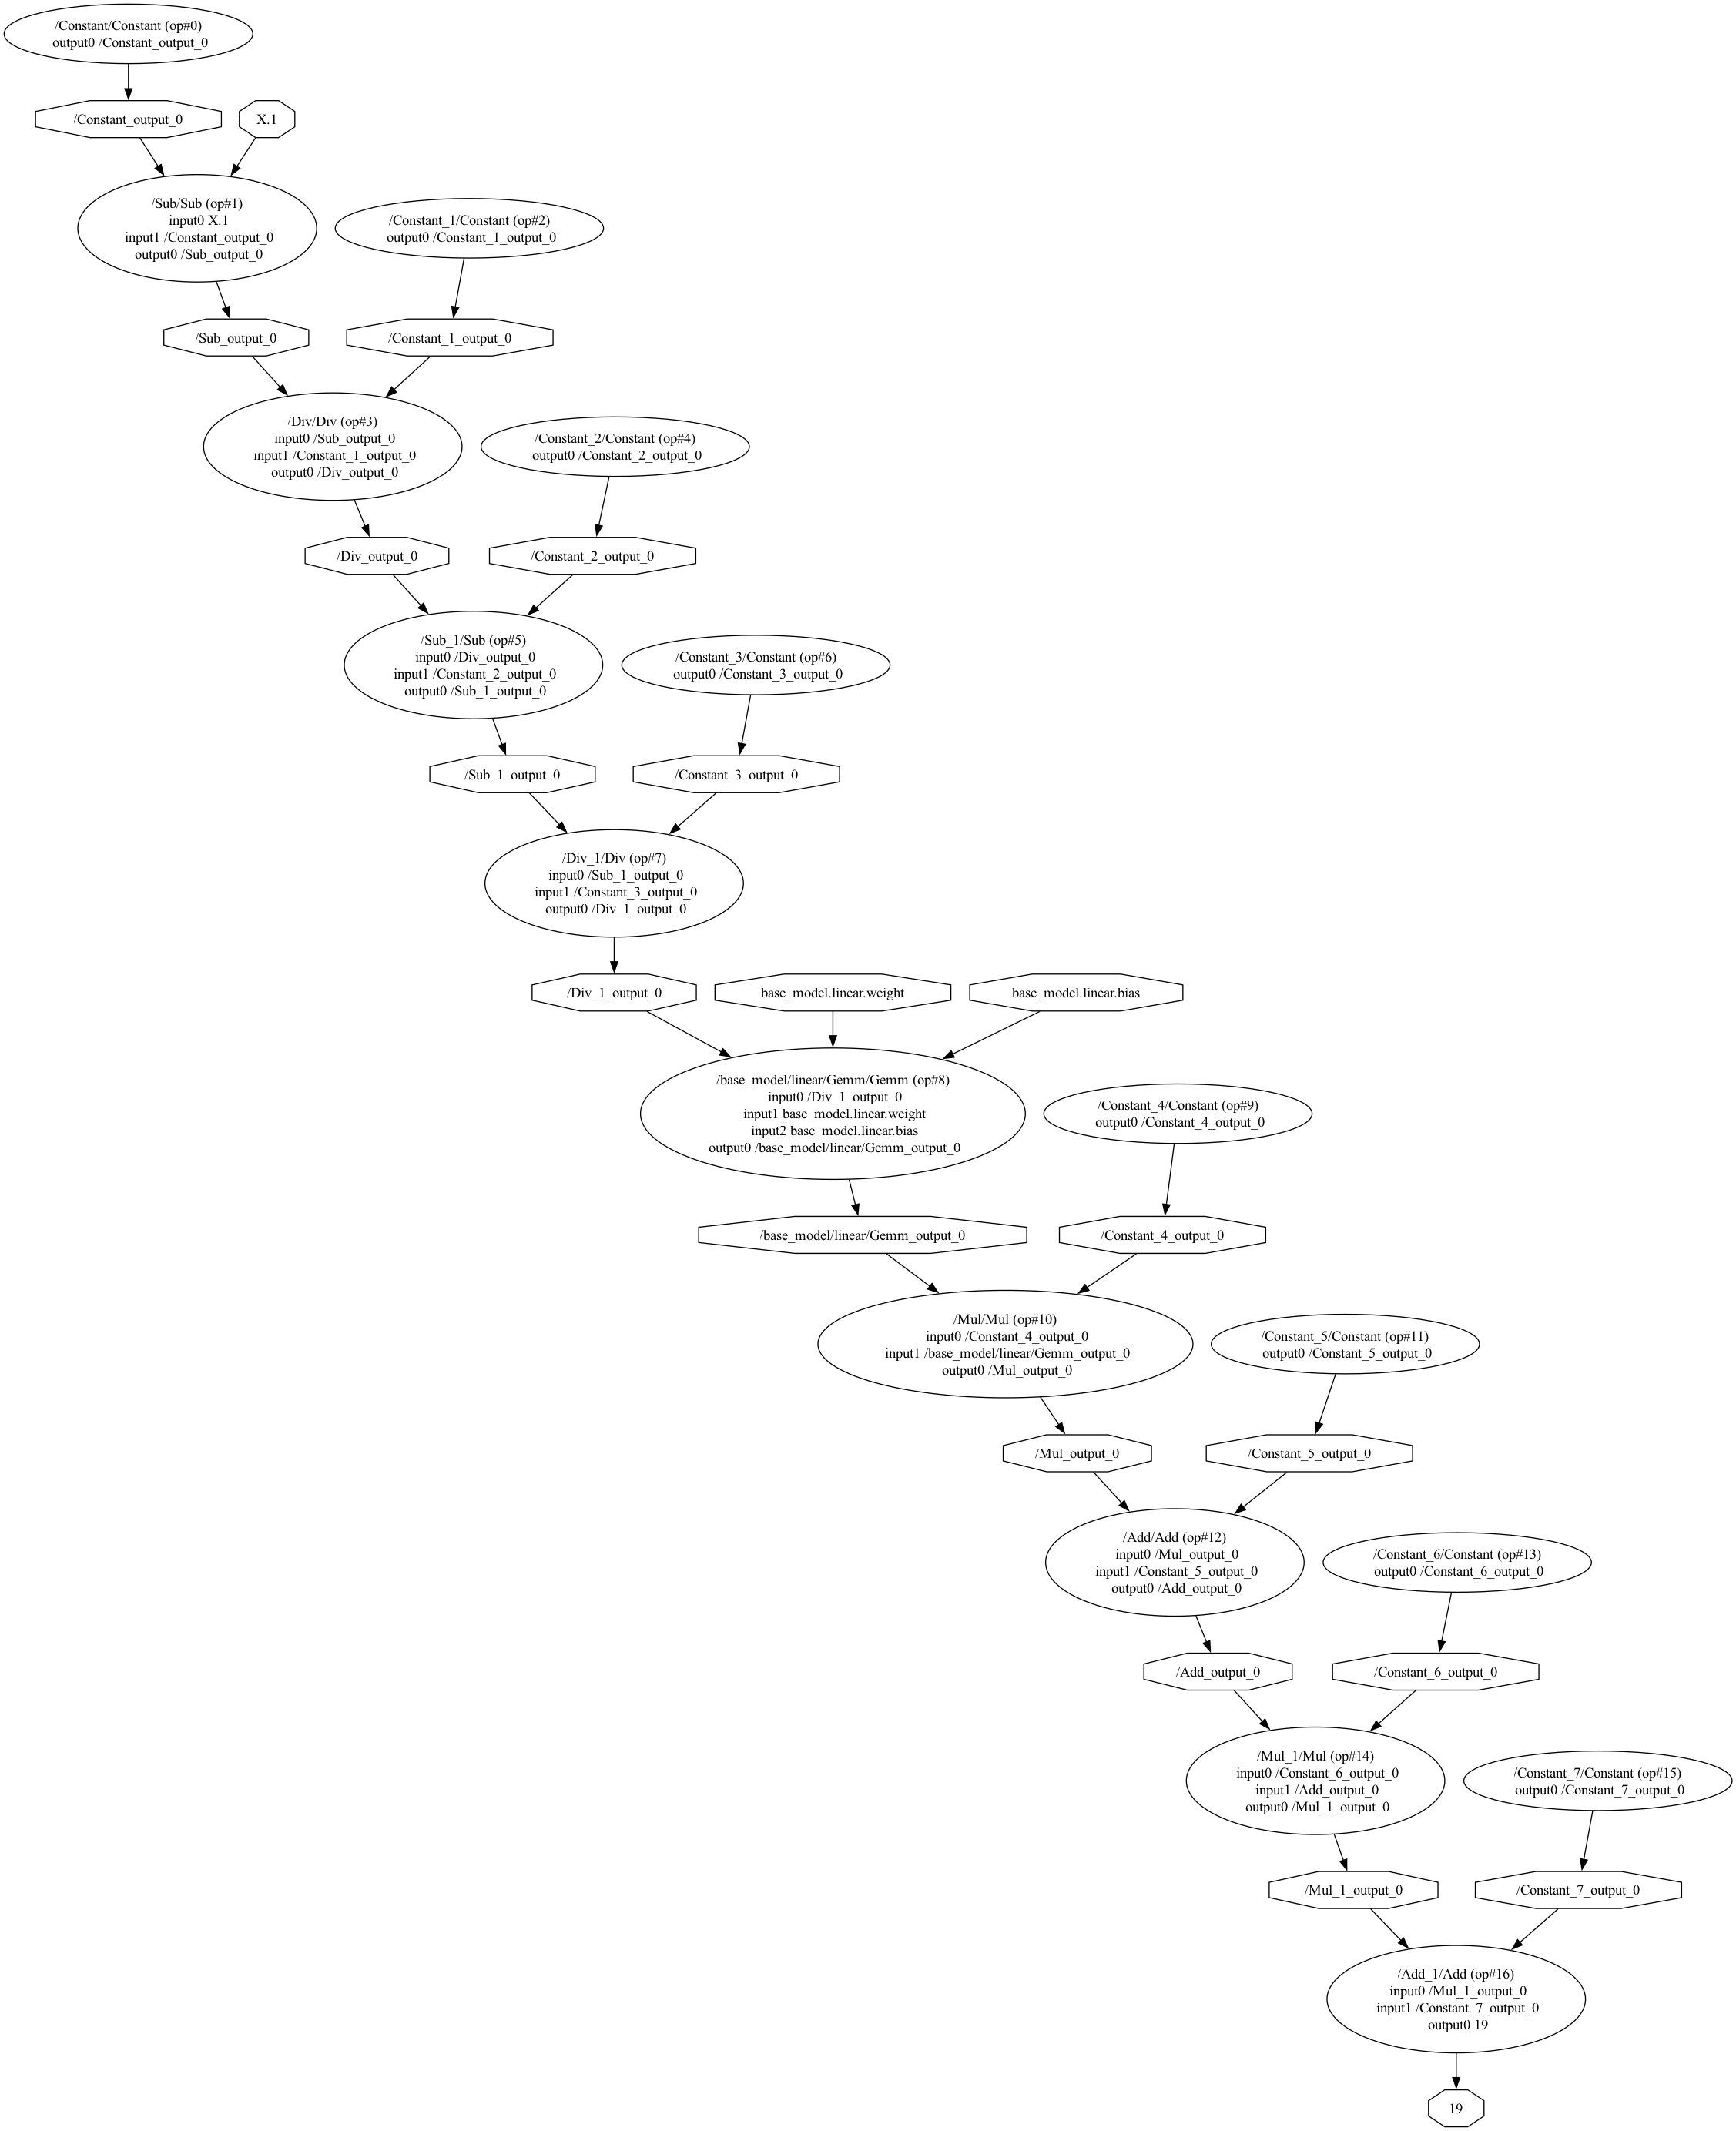

In [66]:
model_path = 'torch_model_extended.onnx'
onnx_model = onnx.load(model_path)
pydot_graph = GetPydotGraph(onnx_model.graph, name=onnx_model.graph.name, rankdir="TB", node_producer=GetOpNodeProducer("docstring"))

pydot_graph.write_png("graph.png")
Image("graph.png")

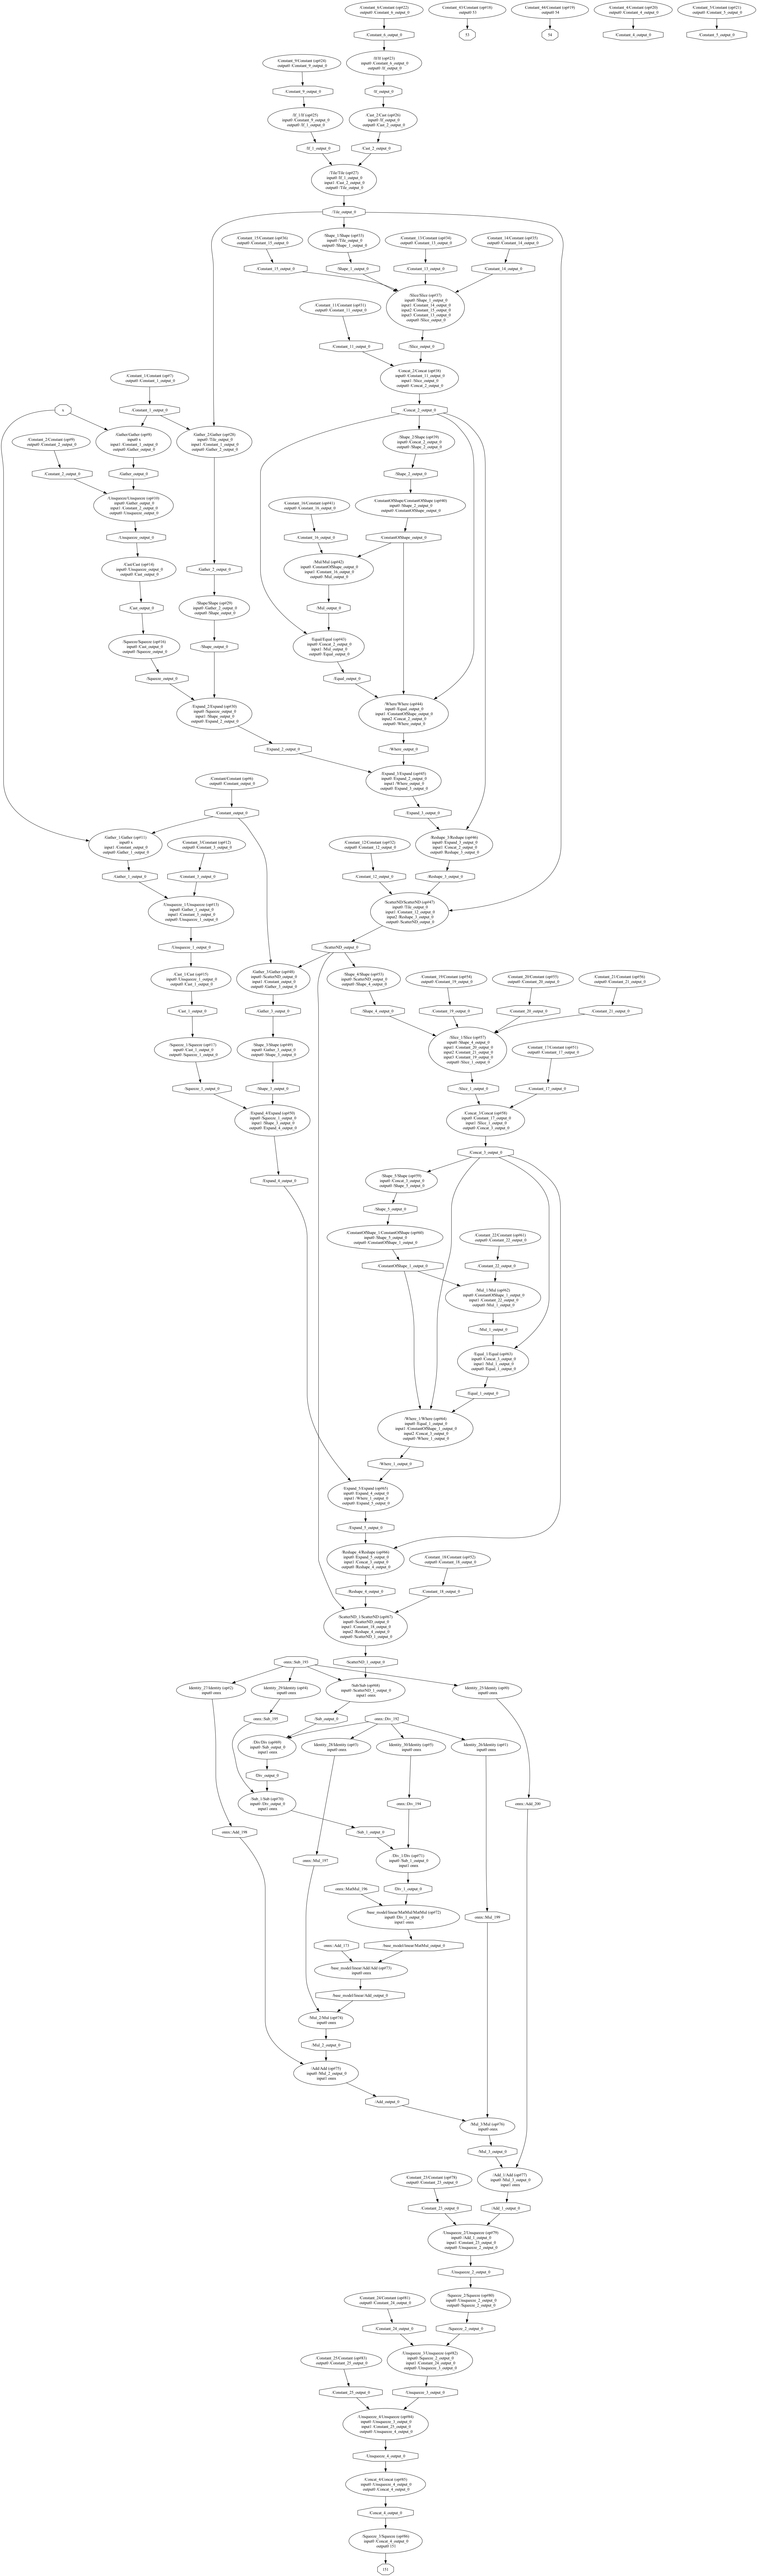

In [67]:
model_path = 'example_module_extended.onnx'
onnx_model = onnx.load(model_path)
pydot_graph = GetPydotGraph(onnx_model.graph, name=onnx_model.graph.name, rankdir="TB", node_producer=GetOpNodeProducer("docstring"))

pydot_graph.write_png("graph.png")
Image("graph.png")

# Changing precision

The TorchModel class has a `precision` attribute that can be set to single or double.

In [15]:
example_model.precision

'double'

In [16]:
input_dict = {'input1': torch.tensor([0.04]), 'input2': torch.tensor([0.14])}
output_dict = example_model.evaluate(input_dict)

print(output_dict)
print(output_dict["output"].dtype)

example_model.precision = "single"
output_dict = example_model.evaluate(input_dict)

print(output_dict)
print(output_dict["output"].dtype)

{'output': tensor(6.2820)}
torch.float64
{'output': tensor(6.2820)}
torch.float32


# Save/load variables to YAML

In [17]:
example_model.input_variables

[ScalarVariable(name='input1', default_value=0.1, value_range=(0.0, 1.0), is_constant=False, unit=None),
 ScalarVariable(name='input2', default_value=0.2, value_range=(0.0, 1.0), is_constant=False, unit=None)]

In [18]:
example_model.output_variables

[ScalarVariable(name='output', default_value=None, value_range=(-inf, inf), is_constant=False, unit=None)]

In [19]:
variables = {
    "input_variables": example_model.input_variables,
    "output_variables": example_model.output_variables
}

In [20]:
from lume_model.utils import variables_as_yaml
print(variables_as_yaml(**variables))

input_variables:
  input1:
    variable_class: ScalarVariable
    default_value: 0.1
    value_range: [0.0, 1.0]
    is_constant: false
  input2:
    variable_class: ScalarVariable
    default_value: 0.2
    value_range: [0.0, 1.0]
    is_constant: false
output_variables:
  output:
    variable_class: ScalarVariable
    value_range: [-.inf, .inf]
    is_constant: false



# Input/output validation demo

## Add more input data

In [21]:
input_data = torch.tensor([[0.5, 0.5], [0.1, 0.5]], dtype=torch.double)
# PyTorch model
model(input_data)

tensor([[6.1250],
        [6.1050]], dtype=torch.float64)

In [22]:
# TorchModule
example_module(input_data)

tensor([6.1250, 6.1050])

In [23]:
# TorchModel
input_dict = {'input1': torch.tensor([0.5, 0.1]), 'input2': torch.tensor([0.5, .5])}
example_model.evaluate(input_dict)

{'output': tensor([6.1250, 6.1050])}

## Range validation

The range for each variable can be optionally defined when instantiating the ScalarVariable class (or in the YAML). If it is not defined, it will be set as (-inf, inf).

The LUMEBaseModel class has `input_validation_config` and `output_validation_config` attributes that the user can define. For example: 
```
input_validation_config = {
    "input1" : {
            "value_range": True,
            "strict": False
    }
}
```

If `value_range` is set to `True`, the value will be checked at each iteration to make sure it's within the provided range. If `strict` is set to `True`, an error will be raised if it's out of range. If it's `False`, then a warning is printed to the console.

Note that while output variables do not typically require a range, if one is provided along with a `output_validation_config` that defines strict range checking, an error will 
be raised when the output is outside of the provided range.

In [24]:
example_model.input_variables

[ScalarVariable(name='input1', default_value=0.1, value_range=(0.0, 1.0), is_constant=False, unit=None),
 ScalarVariable(name='input2', default_value=0.2, value_range=(0.0, 1.0), is_constant=False, unit=None)]

In [25]:
# using default config since none was defined at instantiation
example_model.default_input_validation_config 

{'input1': {'value_range': True, 'strict': False},
 'input2': {'value_range': True, 'strict': False}}

In [26]:
# lax range checking
input_dict = {'input1': torch.tensor([1.2, 0.1]), 'input2': torch.tensor([0.5, .5])}
example_model.evaluate(input_dict)

{'output': tensor([6.1600, 6.1050])}

In [27]:
# change input1's strict value to True
example_model.input_validation_config = {
    "input1": {'value_range': True, 'strict': True},
    "input2": {'value_range': True, 'strict': False}
}

# strict range checking, raises ValueError
input_dict = {'input1': torch.tensor([1.2, 0.1]), 'input2': torch.tensor([0.5, .5])}
example_model.evaluate(input_dict)

ValueError: Value (1.2000000476837158) of 'input1' is out of valid range ([0.0,1.0]).

## Default value validation

The ScalarVariable class has an optional `default_value` attribute. The LUMEBaseModel however does require that input variables have a default value, and will raise an error if any are instantiated without one. When evaluating a TorchModel isntance, an input dict can have missing inputs, and the TorchModel will fill in the missing inputs with the provided default value.

In [28]:
example_model.input_variables

[ScalarVariable(name='input1', default_value=0.1, value_range=(0.0, 1.0), is_constant=False, unit=None),
 ScalarVariable(name='input2', default_value=0.2, value_range=(0.0, 1.0), is_constant=False, unit=None)]

Run w/o specifying input1 value

In [29]:
input_dict = {'input2': torch.tensor([0.5])}
example_model.evaluate(input_dict)

{'output': tensor(6.1050)}

Set default value out of range

In [30]:
example_model.input_variables[0].default_value = 1.2

In [31]:
# strict range checking, raises ValueError
input_dict = {'input2': torch.tensor([0.5])}
example_model.evaluate(input_dict)

ValueError: Value (1.2000000476837158) of 'input1' is out of valid range ([0.0,1.0]).

In [32]:
example_model.input_variables[0].default_value = 0.1

## Constant variables and their validation

Constant variables are defined by setting the ScalarVariable optional class attribute `is_constant` to True. These variables will always have their value equal to the provided default value.

In [33]:
example_model.input_variables[0].is_constant = True

<mark>Case of validation error due to lack of value range checking within specified tolerance

In [34]:
# constant input variable set to , raises ValueError
input_dict = {'input2': torch.tensor([0.5])}
example_model.evaluate(input_dict)

ValueError: Expected value to be 0.1 for constant variable 'input1', but received 0.10000000149011612.

In [35]:
# constant input variable set to , raises ValueError
input_dict = {'input1': torch.tensor([0.5]), 'input2': torch.tensor([0.5])}
example_model.evaluate(input_dict)

ValueError: Expected value to be 0.1 for constant variable 'input1', but received 0.5.